In [230]:
import yfinance as yf
import seaborn as sns

import requests
import pandas as pd

In [231]:
# # CSV

# gold_price = (
#     pd.read_csv('./Gold/gold_usd_data.csv')
#     .assign(
#         date=lambda df: pd.to_datetime(df['date'],dayfirst=True),
#         value=lambda df: pd.to_numeric(df['value'])
#     )
#     .set_index('date')
#     .rename(columns={'value':'nom_price'})
#     .resample('ME').mean()
# )

In [232]:
#   YFinance Pull
gold_price = yf.Ticker("GC=F")
gold_price = (
    gold_price.history(period='max')
    .drop(['Open','High','Low','Volume','Dividends','Stock Splits'],axis=1)
        .assign(
        Close=lambda df: pd.to_numeric(df['Close'])
    )
    .rename(columns={'Close':'nom_price'})
    .resample('ME').mean()
)

gold_price.index = gold_price.index.tz_localize(None).rename('date')

In [233]:
#   US CPI

# Define the URL components
root = 'https://api.stlouisfed.org/fred/series/observations'
params = {
    'series_id': 'CPIAUCSL',
    'api_key': '899901ba06f09b9961a73113b1834a15',
    'file_type': 'json'
}

# Fetch the data from the API
response = requests.get(root, params=params)
observations = response.json()['observations']

# Create a DataFrame, process the data, and calculate monthly averages
cpi = (
    pd.DataFrame(observations)
    .drop(columns=['realtime_start', 'realtime_end'])
    .assign(
        date=lambda df: pd.to_datetime(df['date']),
        value=lambda df: pd.to_numeric(df['value'])
    )
    .set_index('date')
    .rename(columns={'value':'usd_index'})
    .resample('ME').mean()  # Monthly resampling and averaging
)

In [234]:
#   US Real 10-YR

# Define the URL components
root = 'https://api.stlouisfed.org/fred/series/observations'
params = {
    'series_id': 'REAINTRATREARAT10Y',
    'api_key': '899901ba06f09b9961a73113b1834a15',
    'file_type': 'json'
}

# Fetch the data from the API
response = requests.get(root, params=params)
observations = response.json()['observations']

# Create a DataFrame, process the data, and calculate monthly averages
real_yield = (
    pd.DataFrame(observations)
    .drop(columns=['realtime_start', 'realtime_end'])
    .assign(
        date=lambda df: pd.to_datetime(df['date']),
        value=lambda df: pd.to_numeric(df['value'])
    )
    .set_index('date')
    .rename(columns={'value':'real_rate'})
    .resample('ME').mean()  # Monthly resampling and averaging
)

In [235]:
merged = (
    pd.merge(gold_price, real_yield,how='left',left_index=True,right_on='date')
    .merge(cpi,how='left',left_on='date',right_on='date')
    .dropna()
    .assign(   
        usd_index = lambda df:1/(df['usd_index']/df['usd_index'].iloc[0]),
        real_price = lambda df: df['nom_price']*df['usd_index']
        )
    #.set_index('date')
)   

In [236]:
pre_cov=merged.loc[merged.index.year.isin(range(2006,2020))]

<Axes: xlabel='date', ylabel='real_rate'>

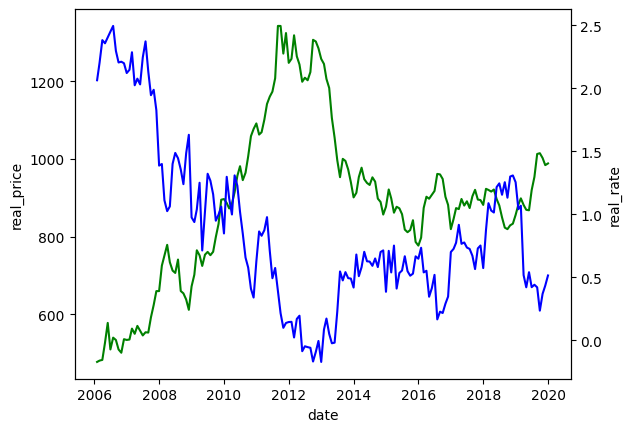

In [237]:
import matplotlib.pyplot as plt
sns.lineplot(data=pre_cov['real_price'], color="g")
ax2 = plt.twinx()
sns.lineplot(data=pre_cov['real_rate'], color="b", ax=ax2)

<Axes: xlabel='real_rate', ylabel='real_price'>

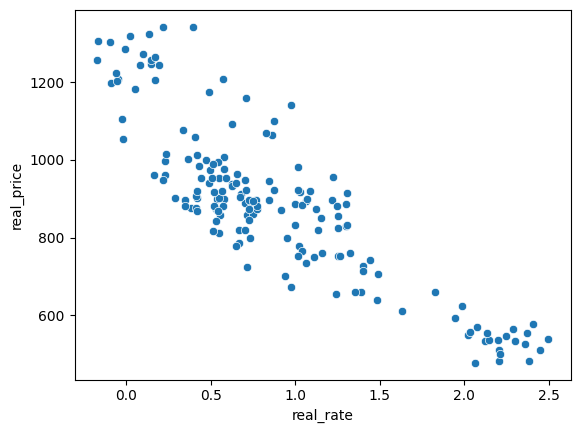

In [238]:
sns.scatterplot(pre_cov,x='real_rate',y='real_price')

In [239]:
post_cov=merged.loc[merged.index.year>2019]

<Axes: xlabel='date', ylabel='real_rate'>

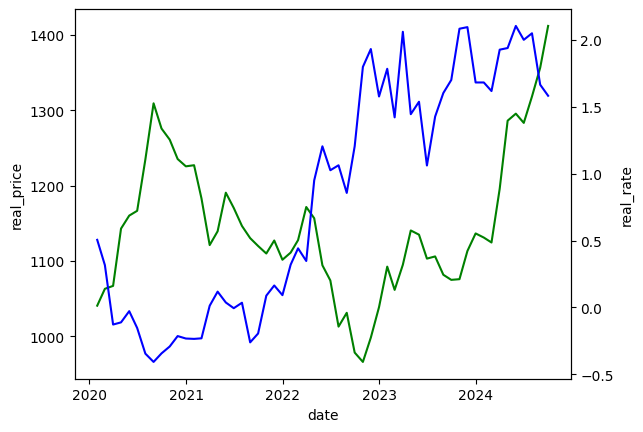

In [245]:
import matplotlib.pyplot as plt
sns.lineplot(data=post_cov['real_price'], color="g")
ax2 = plt.twinx()
sns.lineplot(data=post_cov['real_rate'], color="b", ax=ax2)

#sns.lineplotplot(post_cov,x='real_rate',y='real_price')

US Deficit